1. 런타임유형 GPU로 변경 후 GPU사용 가능여부 확인



In [15]:
import tensorflow as tf

# GPU 사용 가능 여부 확인
if tf.test.gpu_device_name():
    print("GPU 사용 가능")
    # 현재 GPU 디바이스 이름 출력
    print("GPU 디바이스 이름:", tf.test.gpu_device_name())
else:
    print("GPU 사용 불가능")

GPU 사용 가능
GPU 디바이스 이름: /device:GPU:0


2.구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


3.압축풀기

In [3]:
!unzip -qq "/content/drive/MyDrive/인공지능자동차데이터/video.zip"

replace video/train_01813_135.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


4.라이브러리 불러오기

In [4]:
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

5.데이터 불러오기

image_path: /content/video/train_01843_135.png
steering_Angle: 135


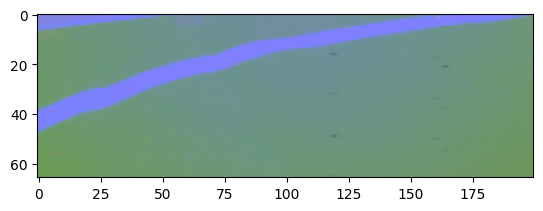

In [5]:
data_dir = '/content/video'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

6.조향각의 분포를 확인



(array([566.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1618.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1084.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <BarContainer object of 25 artists>)

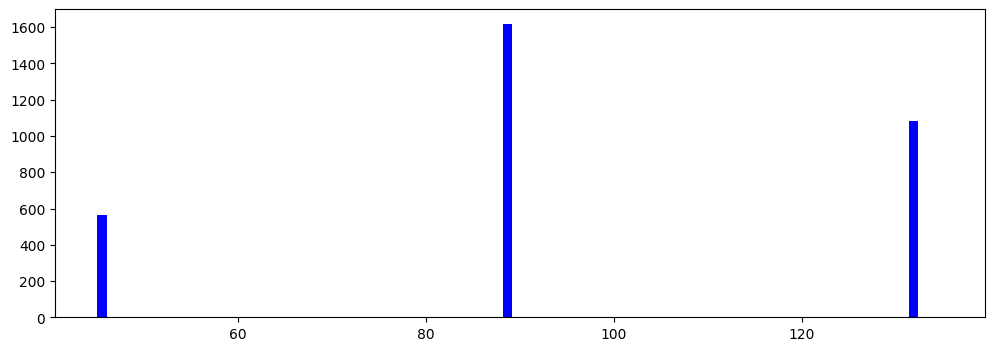

In [6]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

7. 학습데이터와 검증데이터를 분리

Training data: 2614
Validation data: 654


Text(0.5, 1.0, 'Validation Data')

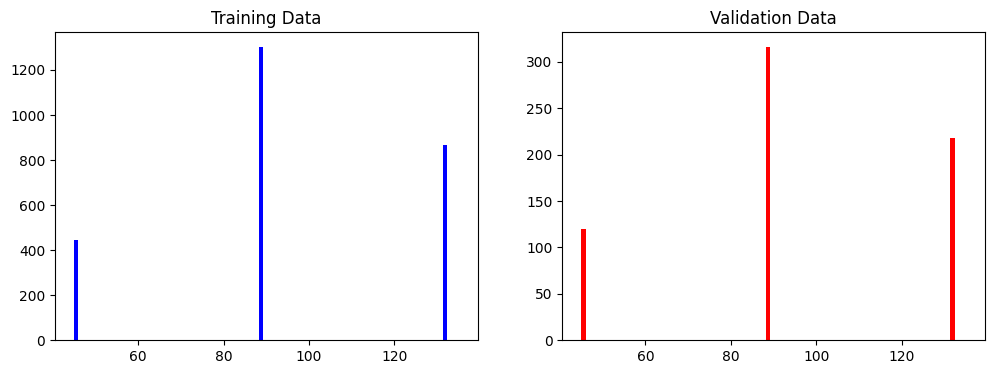

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

8. 이미지 읽어오기 및 정규화함수

Text(0.5, 1.0, 'processed')

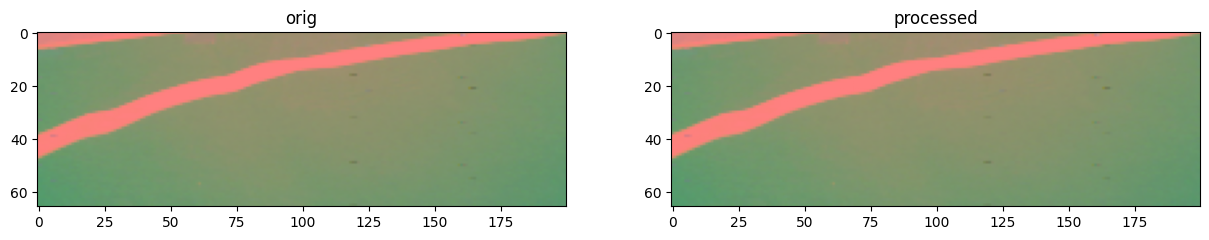

In [8]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    return image

def img_preprocess(image):
    image = image / 255
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

9. nvidia 모델구성

In [9]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')

    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='elu'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    return model

model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout (Dropout)           (None, 3, 20, 64)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)             

10. 학습데이터 생성

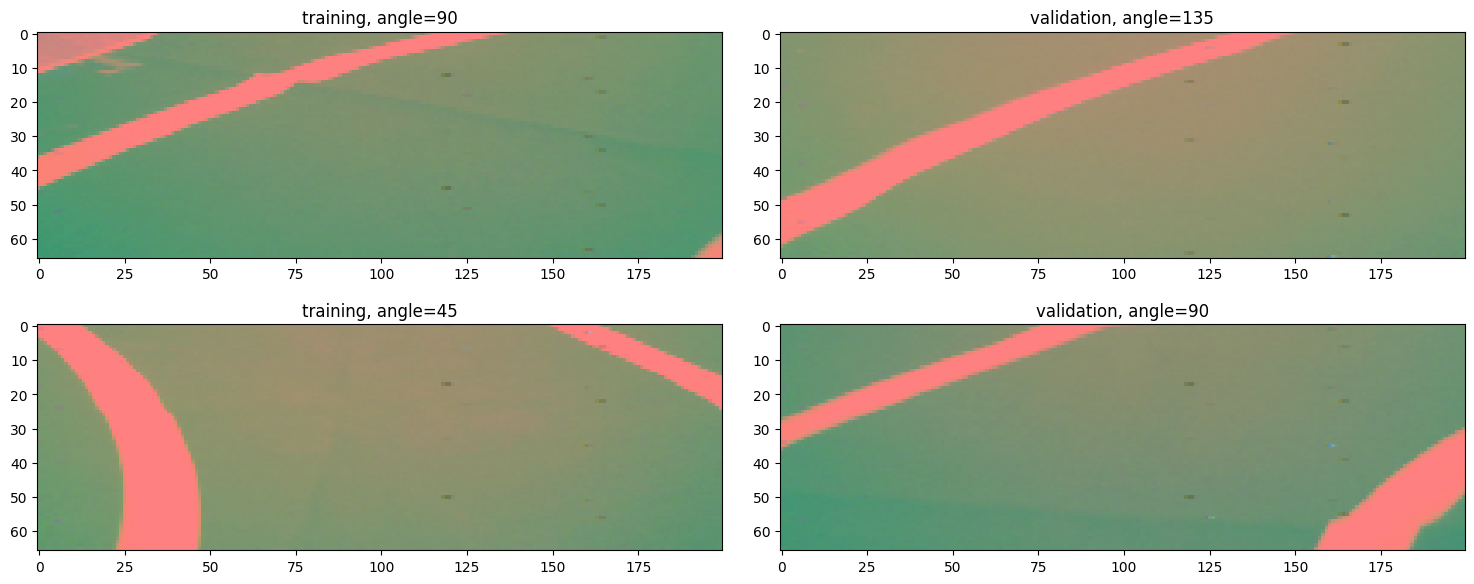

In [10]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]

            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)

        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

11.모델 학습(5~10분가량 소요)

In [11]:
model_output_dir = "/content/drive/MyDrive/인공지능자동차데이터"

checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

<ipython-input-11-cd5748e58390>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100),


Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 1182.2963
Epoch 1: val_loss improved from inf to 999.54437, saving model to /content/drive/MyDrive/인공지능자동차데이터/lane_navigation_check.h5
300/300 [==============================] - 54s 148ms/step - loss: 1182.2963 - val_loss: 999.5444
Epoch 2/10
  3/300 [..............................] - ETA: 9s - loss: 1032.6550 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - ETA: 0s - loss: 890.1534
Epoch 2: val_loss improved from 999.54437 to 511.36896, saving model to /content/drive/MyDrive/인공지능자동차데이터/lane_navigation_check.h5
300/300 [==============================] - 47s 156ms/step - loss: 890.1534 - val_loss: 511.3690
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 457.8329
Epoch 3: val_loss improved from 511.36896 to 417.00406, saving model to /content/drive/MyDrive/인공지능자동차데이터/lane_navigation_check.h5
300/300 [==============================] - 39s 131ms/step - loss: 457.8329 - val_loss: 417.0041
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 417.8969
Epoch 4: val_loss improved from 417.00406 to 385.77676, saving model to /content/drive/MyDrive/인공지능자동차데이터/lane_navigation_check.h5
300/300 [==============================] - 46s 152ms/step - loss: 417.8969 - val_loss: 385.7768
Epoch 5/10
300/300 [==============================]

12. 결과확인

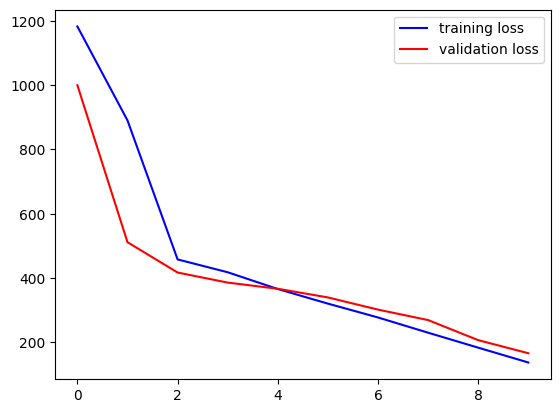

In [12]:
history.history

history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

13. 검증

4/4 [==============================] - 1s 66ms/step
mse       = 2.1e+02
r_squared = 80.46%



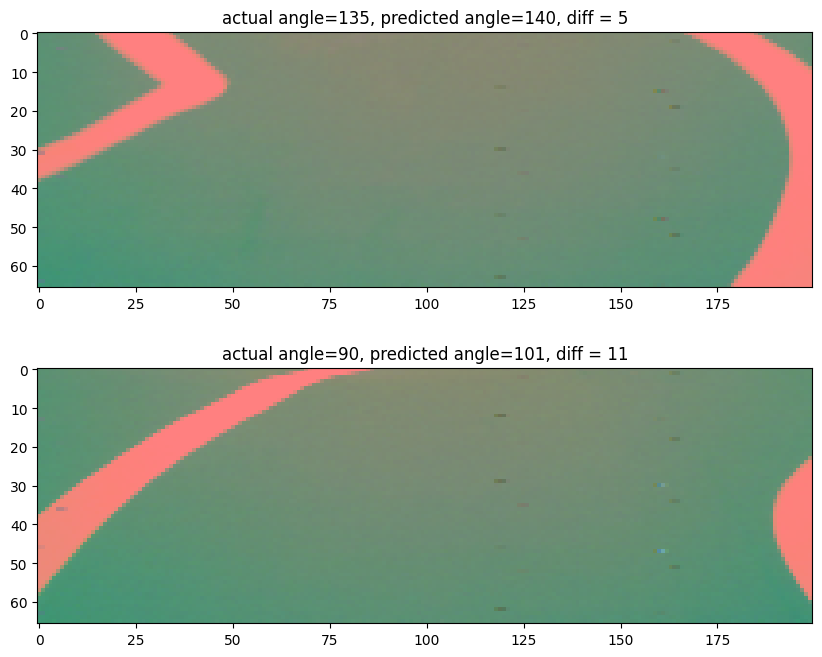

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):

    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)

    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()

def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")

14.video 폴더 삭제 (video 폴더 삭제후 [3.압축풀기] 부터 다시 진행하여 학습)

In [ ]:
import shutil

shutil.rmtree("/content/video")